In [1]:
%matplotlib inline
from matplotlib import style, figure
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflecting an existing database into a new model
Base = automap_base()
# reflecting the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Saving references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Creating session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

# Exploratory Climate Analysis

In [10]:
#viewing table names
table_names = inspector.get_table_names()
print("Table Names:")
for table in table_names:
    print(table)

#viewing column headers for 'measurement'
print("\n")
print("'Measurement' Headers:")
columns = inspector.get_columns('measurement')
for column in columns:
    print(f"{column['name']}-{column['type']}")
          
#viewing column headers for 'station'
print("\n")
print("'Station' Headers:")
columns = inspector.get_columns('station')
for column in columns:
    print(f"{column['name']}-{column['type']}")

Table Names:
measurement
station


'Measurement' Headers:
id-INTEGER
station-TEXT
date-TEXT
prcp-FLOAT
tobs-FLOAT


'Station' Headers:
id-INTEGER
station-TEXT
name-TEXT
latitude-FLOAT
longitude-FLOAT
elevation-FLOAT


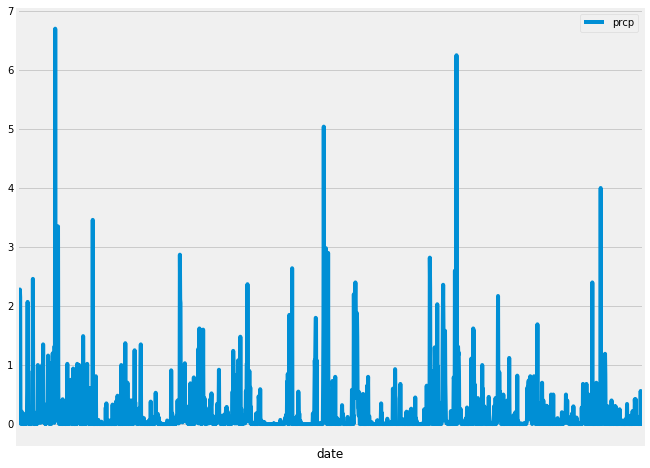

In [11]:
# Designing a query to retrieve the last 12 months of precipitation data and plot the results

# Calculating the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
query_date = dt.date(2017,8,23) - dt.timedelta(days=365)

# Performing a query to retrieve the data and precipitation scores
prcp_measures = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date>=query_date).\
    order_by(Measurement.date.desc())
    
     
# Saving the query results as a Pandas DataFrame, clean null values, and set the index to the date column
df = pd.read_sql(prcp_measures.statement, session.bind)
df_clean = df.dropna().set_index('date')

# Sort the dataframe by date
final_df=df_clean.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
year_temp_plot = final_df.plot(figsize=(10,8),\
                               xticks=[])


![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summ_stat=final_df.describe()
summ_stat.rename(columns={'prcp':'Precipitation'})

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
station_ct = session.query(Station).count()
print(f"There are {station_ct} stations in this dataset")

There are 9 stations in this dataset


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations=session.query(Measurement.station,func.count(Measurement.station).label('Total Data Entries')).\
    group_by(Measurement.station).\
    order_by(desc('Total Data Entries'))
most_active_station = active_stations.first()[0]
most_active_station_data_points = active_stations.first()[1]

for stations in active_stations:
    print(stations)


('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

#grouping the types of data to retreive
sel = [Measurement.date, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

#performing the query
most_active_station_temp_data = session.query(*sel).\
    filter(Measurement.station==most_active_station)

#MAS = most active station
MAS_min_temp = most_active_station_temp_data[0][1]
MAS_max_temp = most_active_station_temp_data[0][2]
MAS_avg_temp = most_active_station_temp_data[0][3]

print(f"The {most_active_station} station is the most active station with {most_active_station_data_points} data points\
 collected.")
print("\n")
print(f"Observations from Station: {active_stations.first()[0]} (degrees fahrenheit)")
print("--------------------------------------")
print(f"Lowest Temperature Recorded: {MAS_min_temp}")
print(f"Highest Temperature Recorded: {MAS_max_temp}")
print(f"Average Temperature: {round(MAS_avg_temp,2)}")

The USC00519281 station is the most active station with 2772 data points collected.


Observations from Station: USC00519281 (degrees fahrenheit)
--------------------------------------
Lowest Temperature Recorded: 54.0
Highest Temperature Recorded: 85.0
Average Temperature: 71.66


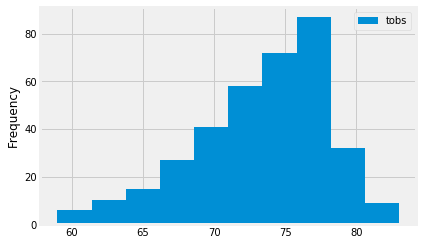

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Calculating the date 1 year ago from the last data point in the database
last_date_most_active = session.query(Measurement.date).\
    filter(Measurement.station==most_active_station).\
    order_by(Measurement.date.desc()).first()
query_date_most_active = dt.date(2017,8,18) - dt.timedelta(days=365)


#Performing a query to retrieve the data and precipitation scores
prcp_measures_most_active = session.query(Measurement.tobs,Measurement.date).\
    filter(Measurement.station==most_active_station).\
    filter(Measurement.date>=query_date_most_active)

df_most_active=pd.read_sql(prcp_measures_most_active.statement, session.bind)
df_most_active.plot(kind='hist')

![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [40]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps('2016-08-13', '2016-08-20')
tmin = my_trip[0][0]
tavg = round(my_trip[0][1],1)
tmax = my_trip[0][2]
trip_start = dt.date(2016,8,13)
trip_end = dt.date(2016,8,20)
peaktopeak=tmax-tmin
print(f"Min: {tmin}")
print(f"Avg: {tavg}")
print(f"Max: {tmax}")


Min: 72.0
Avg: 78.3
Max: 83.0


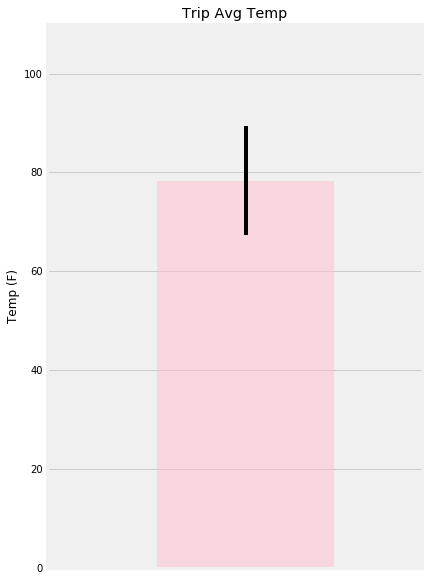

In [41]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

ind = 1    # the x locations for the groups

plt.figure(figsize=(6,10))
plt.xticks([])

plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xlim(.10 , 1.8)
plt.ylim(0,110)

mytrip_temp = plt.bar(ind, tavg, yerr=peaktopeak, color='pink', ecolor="black", align="center", alpha=0.5)


In [42]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
print("Total Rainfall from 8/13/2016 to 8/20/2016")
print("------------------------------------------")
for data in session.query(func.sum(Measurement.prcp),Measurement.station,Station.name,\
        Station.latitude,Station.longitude,Station.elevation).\
        filter(Measurement.station==Station.station).\
        filter(Measurement.date>=trip_start,).\
        filter(Measurement.date<=trip_end).group_by(Measurement.station):
    print(f"\033[1mStation\033[0m: {data[1]}, \033[1mPrecip\033[0m:{round(data[0],2)},\
 \033[1mLocation\033[0m: {round(data[3],2),round(data[4],2)}, \033[1mElv.\033[0m: {data[5]}\n \
  \033[1mName\033[0m:{data[2]}")

Total Rainfall from 8/13/2016 to 8/20/2016
------------------------------------------
Station: USC00513117, Precip:0.61, Location: (21.42, -157.8), Elv.: 14.6
   Name:KANEOHE 838.1, HI US
Station: USC00514830, Precip:0.1, Location: (21.52, -157.84), Elv.: 7.0
   Name:KUALOA RANCH HEADQUARTERS 886.9, HI US
Station: USC00516128, Precip:6.01, Location: (21.33, -157.8), Elv.: 152.4
   Name:MANOA LYON ARBO 785.2, HI US
Station: USC00517948, Precip:0.0, Location: (21.39, -157.98), Elv.: 11.9
   Name:PEARL CITY, HI US
Station: USC00519281, Precip:1.28, Location: (21.45, -157.85), Elv.: 32.9
   Name:WAIHEE 837.5, HI US
Station: USC00519397, Precip:0.04, Location: (21.27, -157.82), Elv.: 3.0
   Name:WAIKIKI 717.2, HI US
Station: USC00519523, Precip:0.01, Location: (21.34, -157.71), Elv.: 19.5
   Name:WAIMANALO EXPERIMENTAL FARM, HI US


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).first()
    
daily_normals("01-01")

(62.0, 69.15384615384616, 77.0)

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start = dt.datetime.strptime("2016-08-13", "%-y%m-%d")
end = dt.datetime.strptime("08-20", "%m-%d")
# Use the start and end date to create a range of dates
date_generated = [start + dt.timedelta(days=x) for x in range(0, (end-start).days)]

# Stip off the year and save a list of %m-%d strings
vac_days = []

for date in date_generated:
    vac_days.append(date.strftime("%m-%d"))  
# Loop through the list of %m-%d strings and calculate the normals for each date
for date in vac_days:
    normals.append(daily_normals(date))

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dates_df = pd.DataFrame(vac_days,columns=["Dates"])
normals_df = pd.DataFrame(normals, columns=["tmin","tavg","tmax"])
vac_normals_df = pd.concat([dates_df,normals_df], axis=1).set_index('Dates')
vac_normals_df

,tmin,tavg,tmax
Dates,,,
08-13,71.0,76.982456,84.0
08-14,71.0,76.777778,82.0
08-15,69.0,76.471698,83.0
08-16,69.0,76.080000,83.0
08-17,69.0,76.125000,83.0
08-18,70.0,76.923077,84.0
08-19,69.0,75.946429,85.0


(array([0., 1., 2., 3., 4., 5., 6.]), <a list of 7 Text xticklabel objects>)

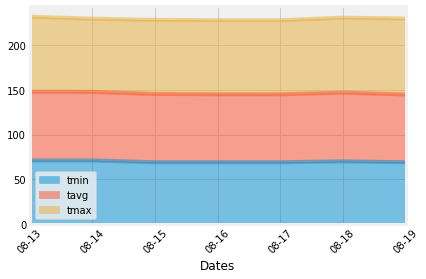

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_plot = vac_normals_df.plot.area(stacked='False', alpha=0.5)
plt.xticks(rotation=45)
